# Annotated Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For tokenization
import json # For loading the dictionary

## Valid & Invalid Word Percentages

### Utility Codes

In [3]:
def load_kbbi_wordlist(
    wordlist_path="/home/haznitrama/scale-resources/dict/kbbi_wordlist.txt",
):
    """
    Loads a list of Indonesian words from a text file (one word per line) and returns a set of unique words (lowercased).
    """
    try:
        with open(wordlist_path, "r", encoding="utf-8") as f:
            words = set(line.strip().lower() for line in f if line.strip())
        return words
    except Exception as e:
        print(f"Error loading KBBI wordlist from {wordlist_path}: {e}")
        return set()


def get_dictionary_words(dict_path: str) -> set:
    """
    Loads and returns a set of valid words from dictionary.
    The keys of this JSON are assumed to be the words.
    """
    try:
        with open(dict_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            # Lowercase dictionary keys for case-insensitive matching
            word_set = set(k.lower() for k in data.keys())  # Lowercase all keys
            if not word_set:
                print(
                    f"Warning: Dictionary loaded from {dict_path} is empty or keys are not Balinese words."
                )
            return word_set
    except FileNotFoundError:
        print(f"Error: Dictionary file not found at {dict_path}")
        return set()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {dict_path}")
        return set()
    except Exception as e:
        print(f"An unexpected error occurred while loading the dictionary: {e}")
        return set()


def calculate_raw_percentages(text, dictionary, kbbi_wordlist=None):
    if pd.isna(text) or not str(text).strip():  # Ensure text is treated as string
        return 0, 0, 0  # valid_p, invalid_p, total_words

    # Simple whitespace and punctuation-based tokenization (adjust if needed)
    # Using str(text).lower() to handle potential non-string types gracefully
    words = re.findall(r"\b\w+\b", str(text).lower())
    total_words = len(words)
    if total_words == 0:
        return 0, 0, 0

    valid_words = 0
    for word in words:
        if word in dictionary:
            valid_words += 1
        elif kbbi_wordlist:
            if word not in kbbi_wordlist:
                valid_words += 1  # Treat as valid if not in KBBI and not in dictionary
    
    invalid_words = total_words - valid_words
    valid_percentage = (valid_words / total_words) * 100 if total_words > 0 else 0
    invalid_percentage = (invalid_words / total_words) * 100 if total_words > 0 else 0

    return valid_percentage, invalid_percentage, total_words


def count_manual_corrections(row, corrections_columns: list) -> int:
    num_corrections = []
    for col in corrections_columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            # Count the number of "->" occurrences in the text
            # This handles cases where multiple corrections might be on the same line
            correction_text = str(row[col]).strip()
            arrow_count = correction_text.count("->")
            num_corrections.append(arrow_count)

    # Take the maximum number of corrections if both are present, or the one available.
    # If a row has no "->" it means no actual correction pair was noted, so count as 0.
    return max(num_corrections) if num_corrections else 0


def map_qc_to_refined_category(qc_input_value, manual_edits, total_words, threshold=25):
    qc_verdict_str = (
        str(qc_input_value).lower() if pd.notna(qc_input_value) else "unknown"
    )

    if "sangat baik" in qc_verdict_str:
        return "Good"
    if "buruk" in qc_verdict_str:
        return "Bad"

    if "dapat diterima" in qc_verdict_str:
        if manual_edits == 0:
            return "Good"
        if total_words > 0:
            edit_ratio = (manual_edits / total_words) * 100
            if edit_ratio > 0 and edit_ratio <= threshold:
                return f"Acceptable (<{threshold}%)"
            elif edit_ratio > threshold:
                return "Bad"
        else:
            return "Bad"

    if qc_verdict_str == "unknown":
        return "Unknown"
    return "Human Other"  # Fallback

In [4]:
bali_idn = get_dictionary_words("/home/haznitrama/scale-resources/dict/bali_idn.json")
cbn_idn = get_dictionary_words("/home/haznitrama/scale-resources/dict/cbn_idn.json")

In [38]:
kbbi = load_kbbi_wordlist()

In [39]:
len(list(cbn_idn))

15681

In [40]:
len(list(bali_idn))

20021

In [41]:
len(list(kbbi))

112651

In [42]:
def process_valid_pct(data_path, dict_path, corrections_columns, threshold=25, use_kbbi=False):
    """
    Processes the DataFrame from the given data path, calculates valid/invalid percentages,
    applies manual corrections, and maps QC verdicts to refined categories.
    """
    # Load the dictionary
    dictionary = get_dictionary_words(dict_path)
    if use_kbbi:
        # Load KBBI wordlist if use_kbbi is True
        kbbi_wordlist = load_kbbi_wordlist()
    else:
        kbbi_wordlist = None

    # Load the DataFrame
    df = pd.read_csv(data_path)
    
    # Calculate valid/invalid percentages
    df["valid_percentage"], df["invalid_percentage"], df["total_words"] = zip(
        *df["Teks Sintetis Awal"].apply(lambda x: calculate_raw_percentages(x, dictionary, kbbi_wordlist))
    )
    
    # Count manual corrections
    df["manual_edits"] = df.apply(lambda row: count_manual_corrections(row, corrections_columns), axis=1)
    
    # Map QC verdicts to refined categories
    df["original_refined_qc_verdict"] = df.apply(
        lambda row: map_qc_to_refined_category(
            row.get("QC Verdict", None),
            row["manual_edits"],
            row["total_words"],
            threshold
        ),
        axis=1
    )
    
    return df

def plot_valid_pct(df, lang="Balinese", threshold=25):
    # --- 4. Analyze Correlations: Plotting and Stats ---
    # Use 'original_refined_qc_verdict' for plotting and stats
    plot_df = df.dropna(
        subset=["original_refined_qc_verdict", "valid_percentage", "invalid_percentage"]
    )
    plot_df = plot_df[
        plot_df["original_refined_qc_verdict"].isin(
            ["Good", f"Acceptable (<{threshold}%)", "Bad"]
        )
    ]

    plt.figure(figsize=(20, 7))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=plot_df,
        x="original_refined_qc_verdict",
        y="valid_percentage",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title("Valid Percentage by Annotation (QC Verdict)")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=plot_df,
        x="original_refined_qc_verdict",
        y="invalid_percentage",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title("Invalid Percentage by Annotation (QC Verdict)")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.suptitle(
        f"Distribution of Metrics by Annotation (QC Verdict) - {lang}",
        fontsize=16,
        y=1.03,
    )
    plt.show()


def print_valid_stats(df, lang="Balinese"):
    print(f"\\nDescriptive Statistics for Metrics by Annotation (QC Verdict) - {lang}")
    for col_stat in ["valid_percentage", "invalid_percentage"]:
        if col_stat in df.columns:
            df[col_stat] = pd.to_numeric(df[col_stat], errors="coerce")

    if "original_refined_qc_verdict" in df.columns:
        print(
            df.dropna(subset=["original_refined_qc_verdict"])
            .groupby("original_refined_qc_verdict")[
                ["valid_percentage", "invalid_percentage"]
            ]
            .describe()
        )
    else:
        print(
            "Warning: Column 'original_refined_qc_verdict' not found for descriptive statistics."
        )

def main_valid_pct(
    data_path: str,
    dict_path: str,
    corrections_columns: list,
    lang: str = "Balinese",
    threshold: int = 25,
    use_kbbi: bool = False
):
    """
    Main function to process the data, calculate valid percentages, and plot results.
    """
    df = process_valid_pct(data_path, dict_path, corrections_columns, threshold, use_kbbi)
    
    # Print descriptive statistics
    print_valid_stats(df, lang)
    
    # Plot valid percentages
    plot_valid_pct(df, lang, threshold)

### Analysis

\nDescriptive Statistics for Metrics by Annotation (QC Verdict) - Balinese
                            valid_percentage                                   \
                                       count       mean        std        min   
original_refined_qc_verdict                                                     
Acceptable (<25%)                      135.0  48.287690  15.734064  12.000000   
Bad                                    101.0  55.671934  12.434747  21.951220   
Good                                    64.0  70.519443  20.956412  15.384615   

                                                                          \
                                   25%        50%        75%         max   
original_refined_qc_verdict                                                
Acceptable (<25%)            37.268519  47.368421  58.797524   89.285714   
Bad                          46.808511  55.000000  64.864865   86.046512   
Good                         63.203463  76.854396  84.9598

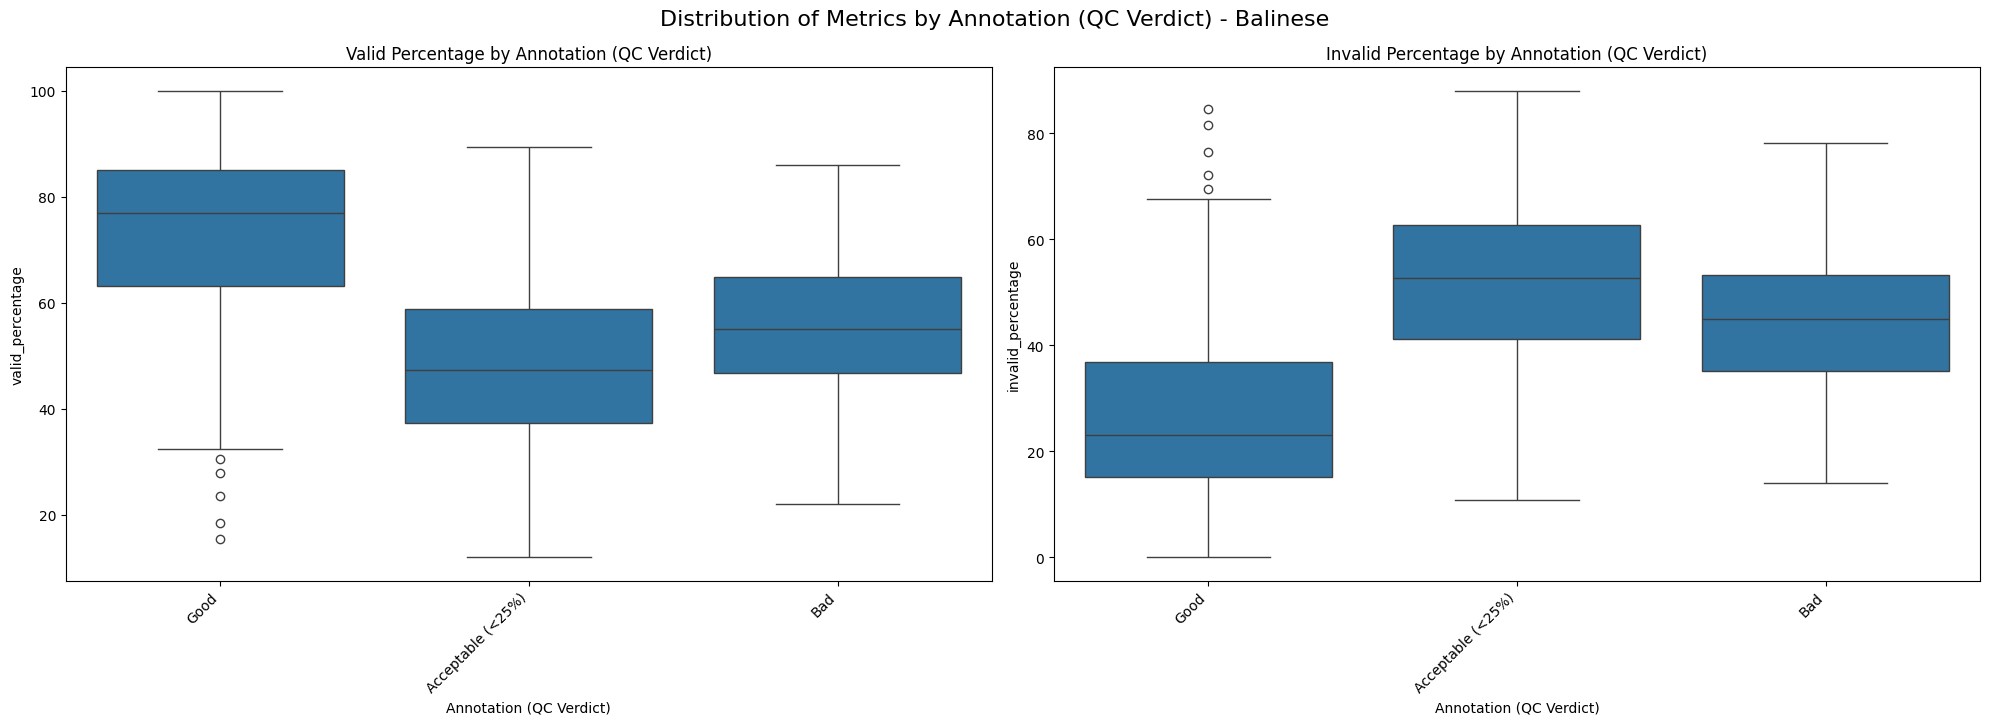

In [43]:
main_valid_pct(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Balinese Quality Check - Annotation Sheets - ban.csv",
    dict_path="/home/haznitrama/scale-resources/dict/bali_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Balinese",
    threshold=25
)

\nDescriptive Statistics for Metrics by Annotation (QC Verdict) - Balinese
                            valid_percentage                                   \
                                       count       mean        std        min   
original_refined_qc_verdict                                                     
Acceptable (<25%)                      135.0  76.226897  11.819778  39.130435   
Bad                                    101.0  76.862592  10.405254  46.875000   
Good                                    64.0  89.814558  11.769141  52.941176   

                                                                           \
                                   25%        50%         75%         max   
original_refined_qc_verdict                                                 
Acceptable (<25%)            69.848485  77.777778   84.000000   97.142857   
Bad                          69.387755  76.315789   84.848485   96.428571   
Good                         84.285714  95.119048  10

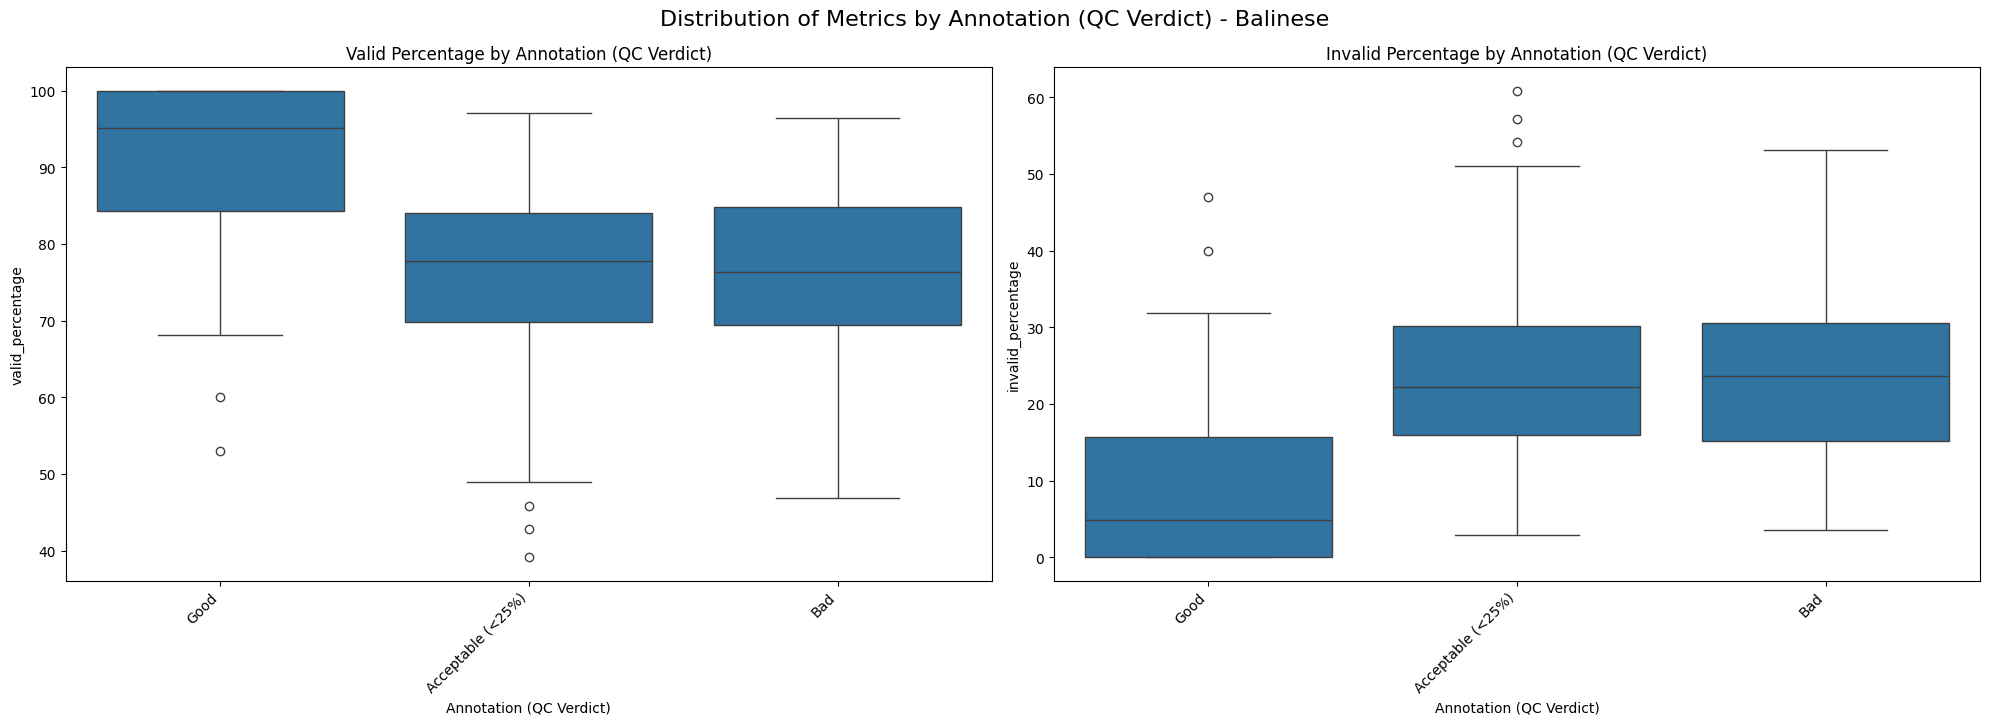

In [44]:
main_valid_pct(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Balinese Quality Check - Annotation Sheets - ban.csv",
    dict_path="/home/haznitrama/scale-resources/dict/bali_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Balinese",
    threshold=25,
    use_kbbi=True
)

\nDescriptive Statistics for Metrics by Annotation (QC Verdict) - Cirebonese
                            valid_percentage                                   \
                                       count       mean        std        min   
original_refined_qc_verdict                                                     
Acceptable (<25%)                      125.0  49.998378  14.651664  11.904762   
Bad                                    138.0  65.482678  13.590364  30.434783   
Good                                    37.0  39.368054  17.685620   6.896552   

                                                                         \
                                   25%        50%        75%        max   
original_refined_qc_verdict                                               
Acceptable (<25%)            40.625000  48.387097  58.333333  88.888889   
Bad                          54.350649  65.367316  75.506757  96.000000   
Good                         24.000000  41.666667  55.000000 

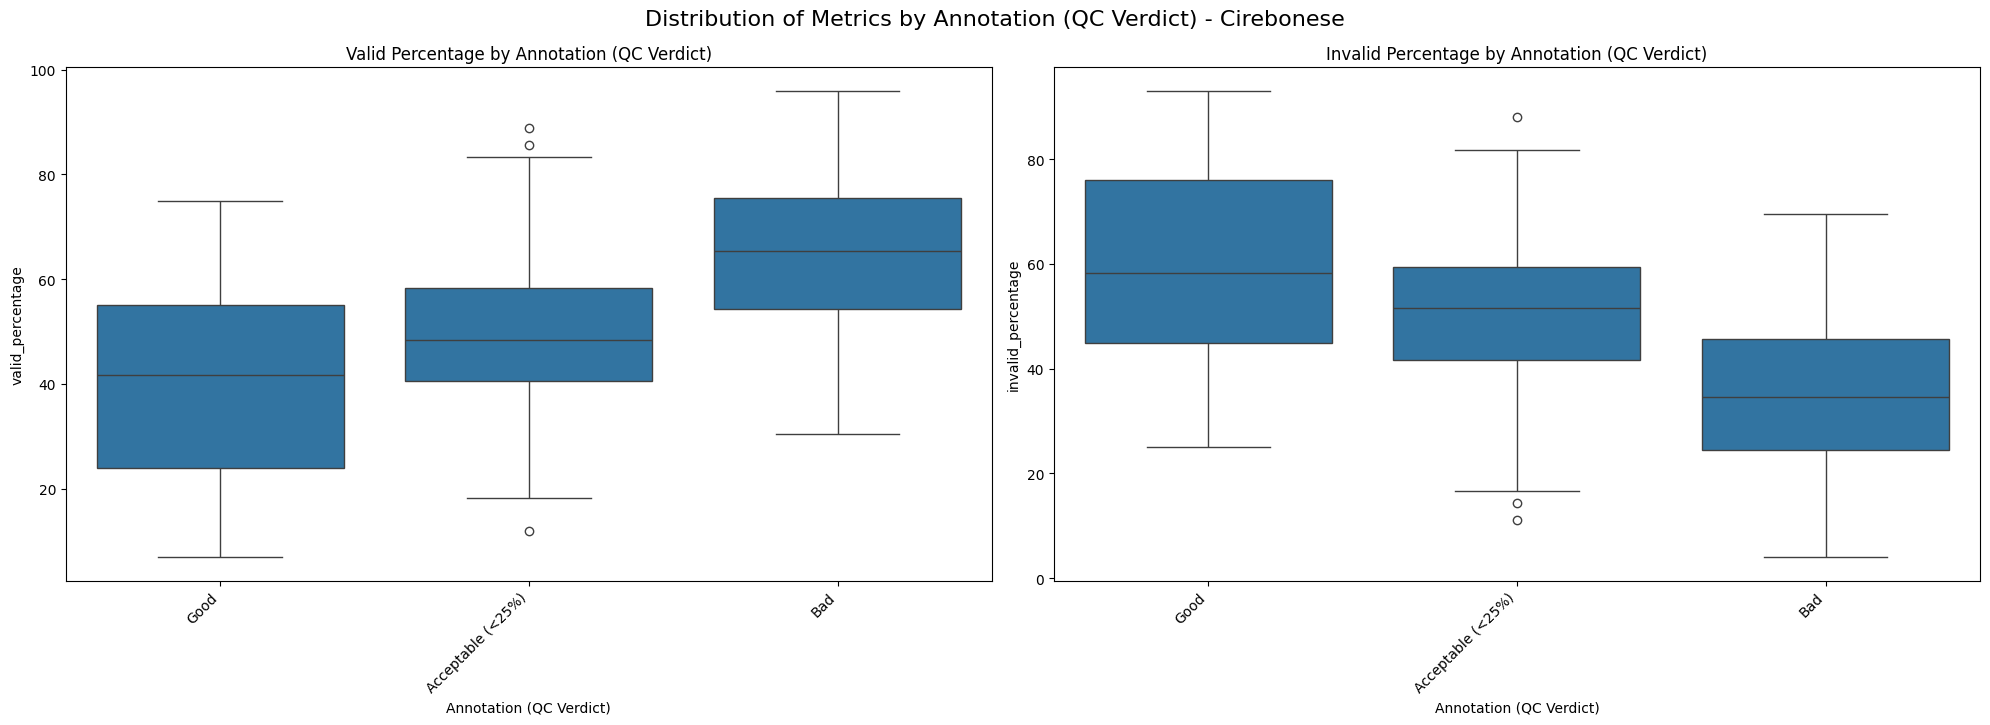

In [45]:
main_valid_pct(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Cirebonese Quality Check - Annotation Sheets - cbn.csv",
    dict_path="/home/haznitrama/scale-resources/dict/cbn_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Cirebonese",
    threshold=25
)

\nDescriptive Statistics for Metrics by Annotation (QC Verdict) - Cirebonese
                            valid_percentage                                   \
                                       count       mean        std        min   
original_refined_qc_verdict                                                     
Acceptable (<25%)                      125.0  76.160901  10.566478  45.161290   
Bad                                    138.0  81.726176   9.668275  51.515152   
Good                                    37.0  74.670735  11.546041  52.000000   

                                                                          \
                                   25%        50%        75%         max   
original_refined_qc_verdict                                                
Acceptable (<25%)            70.000000  76.190476  83.333333   97.619048   
Bad                          75.152439  81.530214  89.470109  100.000000   
Good                         65.517241  74.468085  81.81

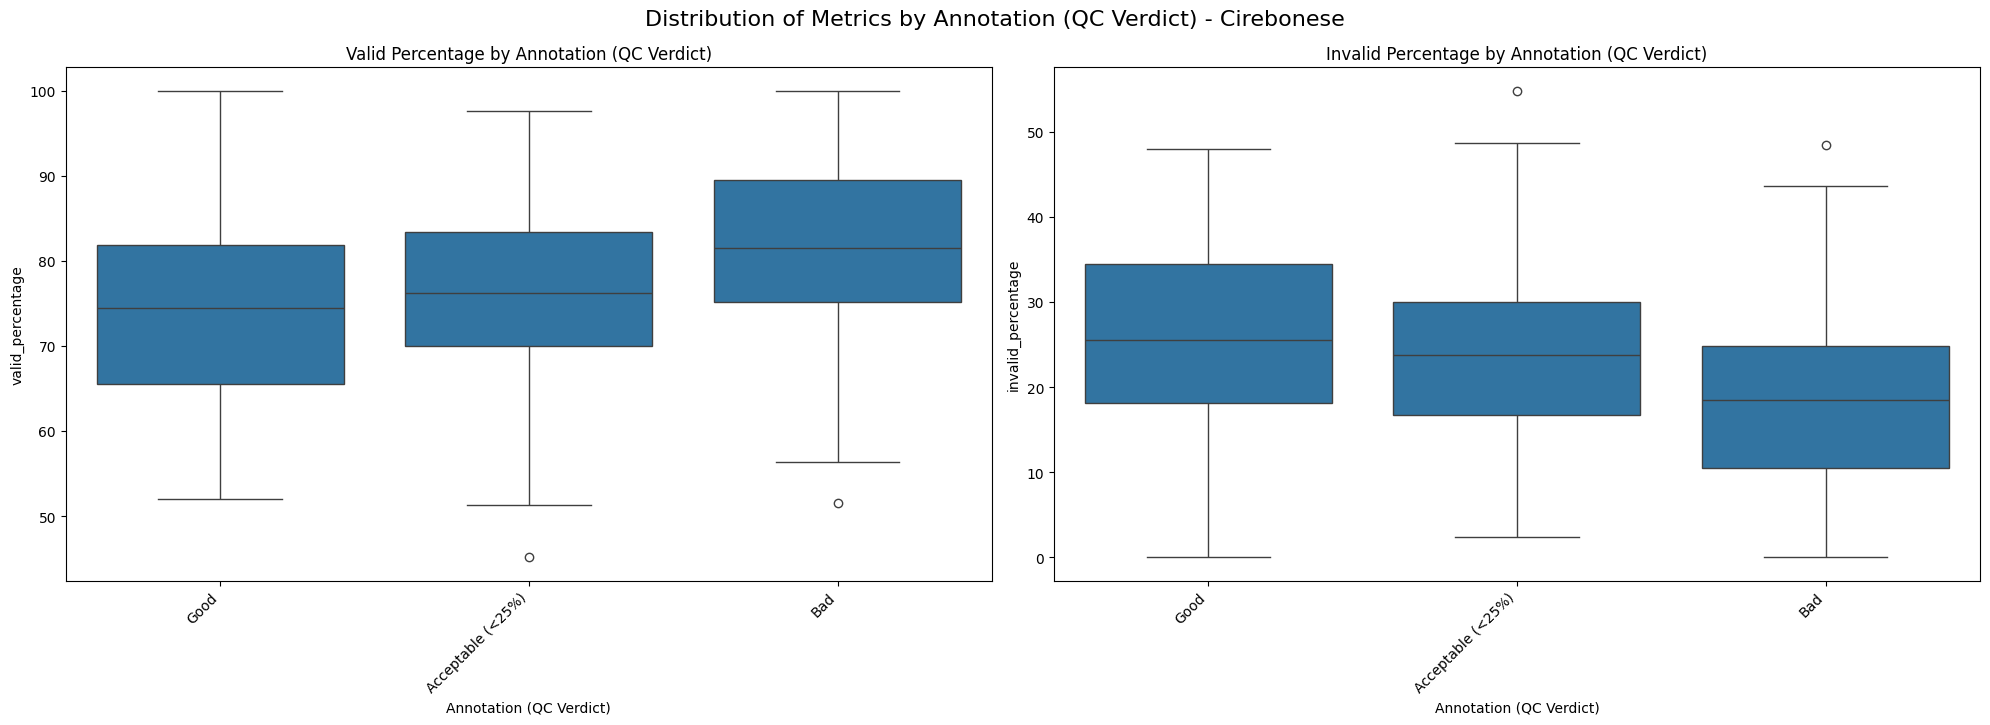

In [46]:
main_valid_pct(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Cirebonese Quality Check - Annotation Sheets - cbn.csv",
    dict_path="/home/haznitrama/scale-resources/dict/cbn_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Cirebonese",
    threshold=25,
    use_kbbi=True
)

## Backtranslation Valid Match Percentages

### Utility Codes

In [14]:
def load_kbbi_wordlist(
    wordlist_path="/home/haznitrama/scale-resources/dict/kbbi_wordlist.txt",
):
    """
    Loads a list of Indonesian words from a text file (one word per line) and returns a set of unique words (lowercased).
    """
    try:
        with open(wordlist_path, "r", encoding="utf-8") as f:
            words = set(line.strip().lower() for line in f if line.strip())
        return words
    except Exception as e:
        print(f"Error loading KBBI wordlist from {wordlist_path}: {e}")
        return set()

def load_dict_map(dictionary_path):
    """Loads translation dictionary."""
    try:
        with open(dictionary_path, "r", encoding="utf-8") as f:
            raw_map = json.load(f)
        # Lowercase keys and values for case-insensitive matching
        dict_map = {}
        for k, v in raw_map.items():
            key = k.lower()
            if isinstance(v, str):
                dict_map[key] = [v.lower()]
            elif isinstance(v, list):
                dict_map[key] = [item.lower() for item in v if isinstance(item, str)]
            else:
                dict_map[key] = []
        print(
            f"Successfully loaded dictionary from {dictionary_path} with {len(dict_map)} entries."
        )
        return dict_map
    except FileNotFoundError:
        print(f"Error: Dictionary file not found at {dictionary_path}")
        return {}
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {dictionary_path}")
        return {}
    except Exception as e:
        print(f"An unexpected error occurred while loading the dictionary: {e}")
        return {}


# 2. Define function to calculate translation match metrics
def calculate_translation_match_metrics(row, dict_map, id_tokens_set=set()):
    """Calculates translation match metrics for a given row."""
    text = row.get("Teks Sintetis Awal")
    ref_text = row.get("Teks Referensi")

    default_series = pd.Series(
        [0, 0, 0, 0, 0],
        index=[
            "bt_valid_match_percentage",
            "bt_invalid_match_percentage",
            "bt_valid_match_count",
            "bt_invalid_match_count",
            "bt_total_src_words",
        ],
    )

    if (
        pd.isna(text)
        or pd.isna(ref_text)
        or not str(text).strip()
        or not str(ref_text).strip()
        or not dict_map
    ):
        return default_series

    translation_tokens = re.findall(r"\b\w+\b", str(text).lower())
    idn_tokens = re.findall(r"\b\w+\b", str(ref_text).lower())

    if not translation_tokens:
        return default_series

    total_bal_words = len(translation_tokens)
    idn_tokens_set = set(idn_tokens)  # global set of reference tokens

    valid_translation_count = 0
    for bal_word in translation_tokens:
        translations = dict_map.get(bal_word, [])
        if not translations and bal_word not in id_tokens_set:
                    translations = [bal_word]  # If no translation found and not an id word, 

        translations = [
            t.lower() for t in translations
        ]  # Lowercase translations for case-insensitive matching

        # if any translation occurs anywhere in the reference tokens
        if any(t in idn_tokens_set for t in translations):
            valid_translation_count += 1

    invalid_translation_count = total_bal_words - valid_translation_count
    valid_percentage = (
        (valid_translation_count / total_bal_words) * 100 if total_bal_words > 0 else 0
    )
    invalid_percentage = (
        (invalid_translation_count / total_bal_words) * 100
        if total_bal_words > 0
        else 0
    )

    return pd.Series(
        [
            valid_percentage,
            invalid_percentage,
            valid_translation_count,
            invalid_translation_count,
            total_bal_words,
        ],
        index=[
            "bt_valid_match_percentage",
            "bt_invalid_match_percentage",
            "bt_valid_match_count",
            "bt_invalid_match_count",
            "bt_total_src_words",
        ],
    )


def process_translation_metrics(
    data_path, dict_path, corrections_columns, threshold=25, use_kbbi=False
):
    """
    Processes the DataFrame from the given data path, calculates translation match metrics.
    """
    # Load the dictionary
    dict_map = load_dict_map(dict_path)
    id_tokens_set = load_kbbi_wordlist() if use_kbbi else set()

    # Load the DataFrame
    df = pd.read_csv(data_path)
    df = process_valid_pct(
        data_path,
        dict_path,
        corrections_columns=corrections_columns,
        threshold=threshold,
        use_kbbi=use_kbbi,
    )  # Ensure valid percentages are calculated first

    # Calculate translation match metrics
    metrics_df = df.apply(
        lambda row: calculate_translation_match_metrics(row, dict_map, id_tokens_set), axis=1
    )

    # Combine metrics with original DataFrame
    df = pd.concat([df, metrics_df], axis=1)

    return df


def plot_translation_metrics(df, lang="Balinese", threshold=25):
    """
    Plots the translation match metrics.
    """
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df,
        x="original_refined_qc_verdict",
        y="bt_valid_match_percentage",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title(f"Valid Translation Match Percentage by Annotation ({lang})")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df,
        x="original_refined_qc_verdict",
        y="bt_invalid_match_percentage",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title(f"Invalid Translation Match Percentage by Annotation ({lang})")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.suptitle(
        f"Distribution of Translation Match Metrics by Annotation ({lang})",
        fontsize=16,
        y=1.03,
    )
    plt.show()


def print_translation_stats(df, lang="Balinese"):
    """
    Prints descriptive statistics for translation match metrics.
    """
    print(
        f"\nDescriptive Statistics for Translation Match Metrics by Annotation ({lang})"
    )
    if "original_refined_qc_verdict" in df.columns:
        stats = (
            df.dropna(subset=["original_refined_qc_verdict"])
            .groupby("original_refined_qc_verdict")[
                [
                    "bt_valid_match_percentage",
                    "bt_invalid_match_percentage",
                    "bt_valid_match_count",
                    "bt_invalid_match_count",
                    "bt_total_src_words",
                ]
            ]
            .describe()
        )
        print(stats)
    else:
        print(
            "Warning: Column 'original_refined_qc_verdict' not found for descriptive statistics."
        )


def main_translation_metrics(
    data_path: str,
    dict_path: str,
    corrections_columns: list,
    lang: str = "Balinese",
    threshold: int = 25,
    use_kbbi: bool = False,
):
    """
    Main function to process the data, calculate translation match metrics, and plot results.
    """
    df = process_translation_metrics(data_path, dict_path, corrections_columns, threshold, use_kbbi)

    # Print descriptive statistics
    print_translation_stats(df, lang)

    # Plot translation match metrics
    plot_translation_metrics(df, lang, threshold)

### Analysis

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/bali_idn.json with 20021 entries.

Descriptive Statistics for Translation Match Metrics by Annotation (Balinese)
                            bt_valid_match_percentage                        \
                                                count       mean        std   
original_refined_qc_verdict                                                   
Acceptable (<25%)                               135.0  84.137189  12.147766   
Bad                                             101.0  85.070614  11.149470   
Good                                             64.0  57.755642  20.890437   

                                                                         \
                                   min        25%        50%        75%   
original_refined_qc_verdict                                               
Acceptable (<25%)            33.333333  80.000000  87.500000  91.666667   
Bad                          30.769231

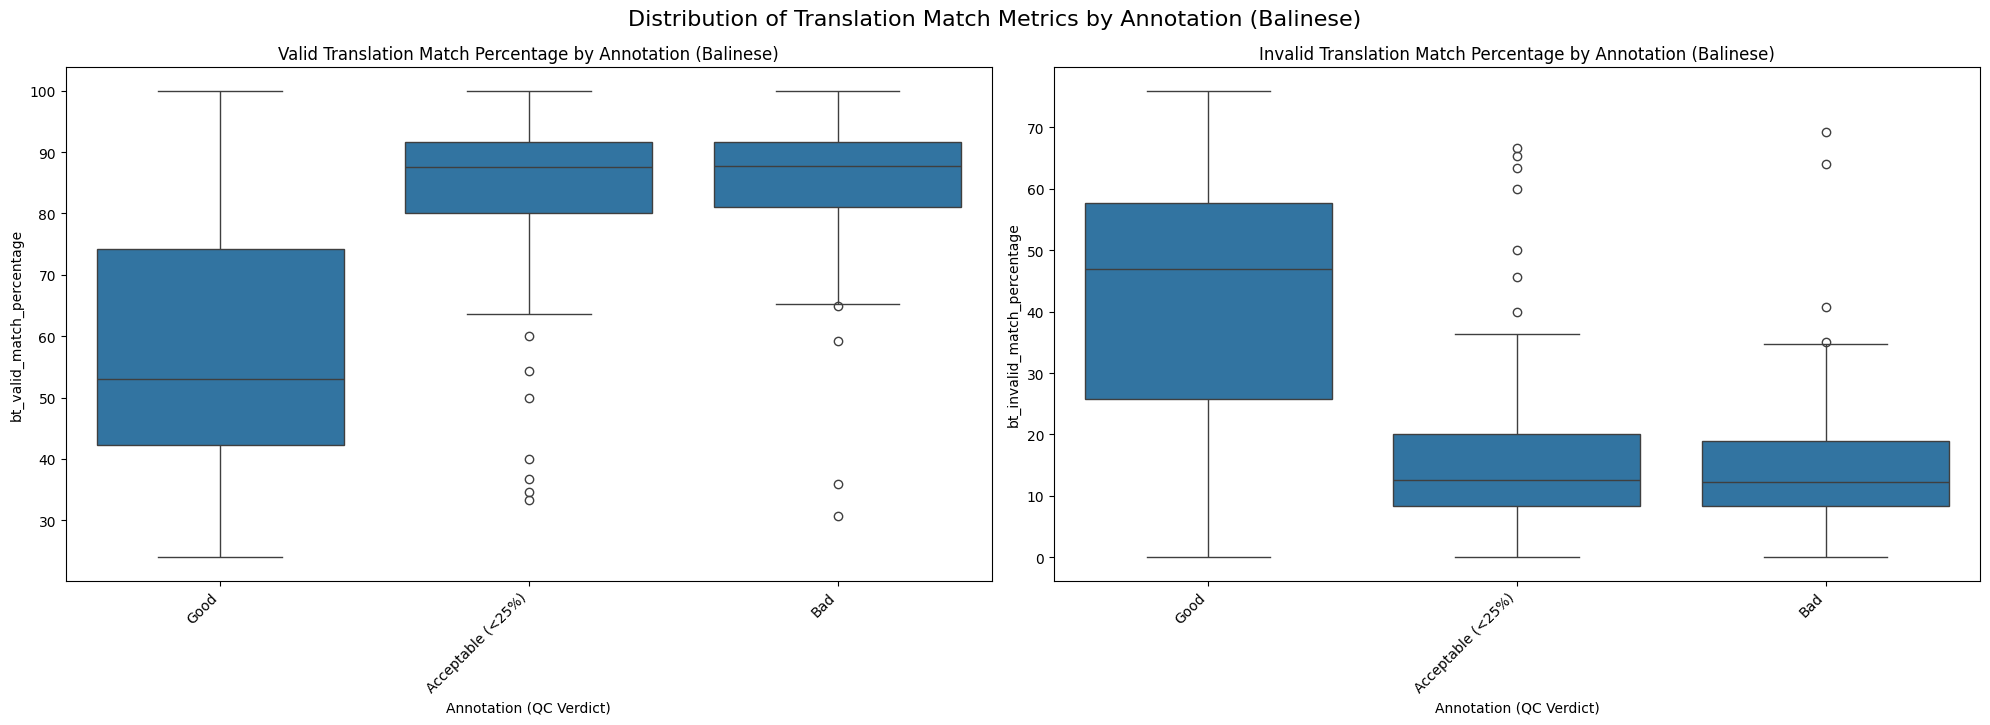

In [15]:
main_translation_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Balinese Quality Check - Annotation Sheets - ban.csv",
    dict_path="/home/haznitrama/scale-resources/dict/bali_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Balinese",
)

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/bali_idn.json with 20021 entries.

Descriptive Statistics for Translation Match Metrics by Annotation (Balinese)
                            bt_valid_match_percentage                        \
                                                count       mean        std   
original_refined_qc_verdict                                                   
Acceptable (<25%)                               135.0  61.099539  13.768662   
Bad                                             101.0  62.806566  12.547410   
Good                                             64.0  49.066212  14.538843   

                                                                         \
                                   min        25%        50%        75%   
original_refined_qc_verdict                                               
Acceptable (<25%)            28.571429  52.565789  60.714286  71.428571   
Bad                          26.923077

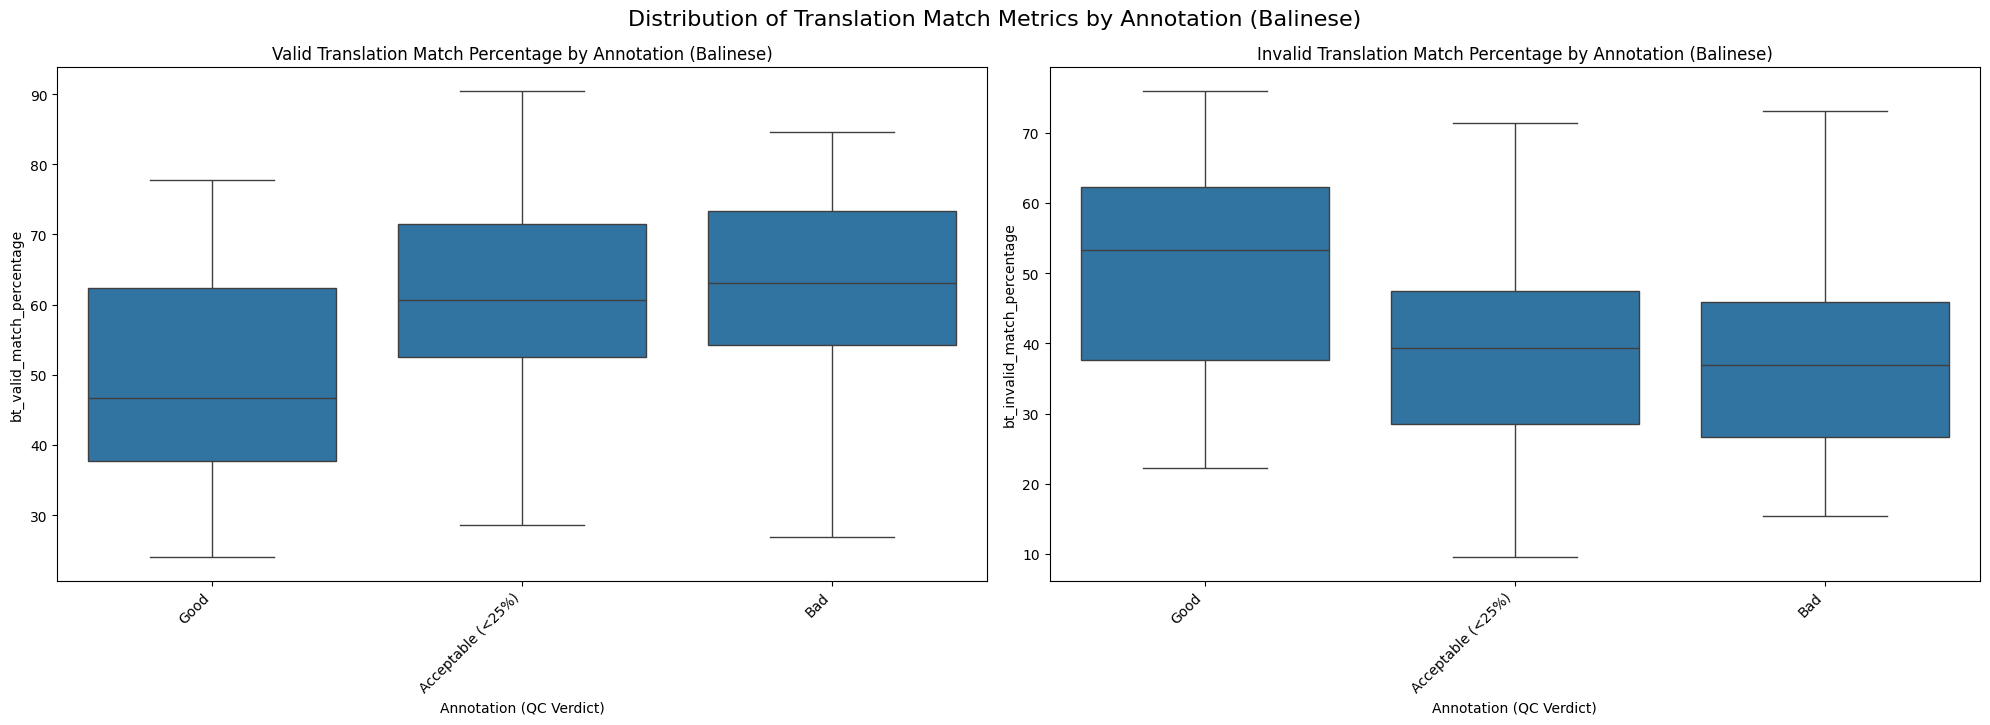

In [16]:
main_translation_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Balinese Quality Check - Annotation Sheets - ban.csv",
    dict_path="/home/haznitrama/scale-resources/dict/bali_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Balinese",
    use_kbbi=True,
)

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/cbn_idn.json with 15681 entries.

Descriptive Statistics for Translation Match Metrics by Annotation (Cirebonese)
                            bt_valid_match_percentage                       \
                                                count       mean       std   
original_refined_qc_verdict                                                  
Acceptable (<25%)                               125.0  83.696468  9.935616   
Bad                                             138.0  79.739011  9.922753   
Good                                             37.0  86.721340  8.091583   

                                                                         \
                                   min        25%        50%        75%   
original_refined_qc_verdict                                               
Acceptable (<25%)            31.818182  79.411765  85.714286  89.583333   
Bad                          52.000000  74.

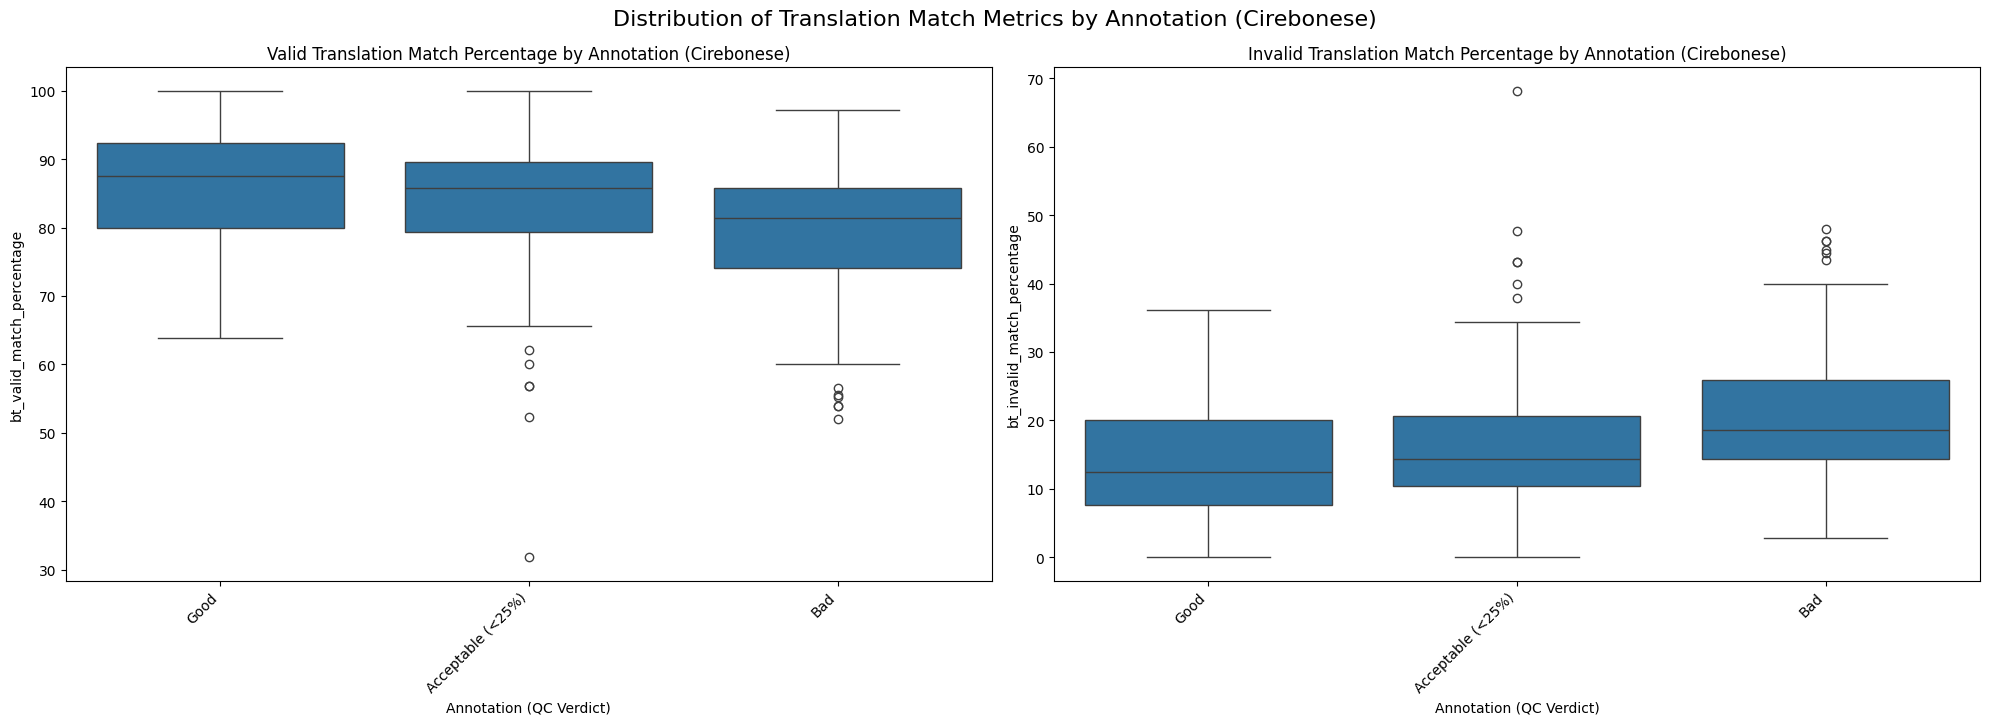

In [37]:
main_translation_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Cirebonese Quality Check - Annotation Sheets - cbn.csv",
    dict_path="/home/haznitrama/scale-resources/dict/cbn_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Cirebonese"
)

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/cbn_idn.json with 15681 entries.

Descriptive Statistics for Translation Match Metrics by Annotation (Cirebonese)
                            bt_valid_match_percentage                        \
                                                count       mean        std   
original_refined_qc_verdict                                                   
Acceptable (<25%)                               125.0  60.857052  11.790055   
Bad                                             138.0  62.754908  11.096085   
Good                                             37.0  61.809208  11.456623   

                                                                         \
                                   min        25%        50%        75%   
original_refined_qc_verdict                                               
Acceptable (<25%)            24.137931  54.545455  61.538462  69.047619   
Bad                          32.00000

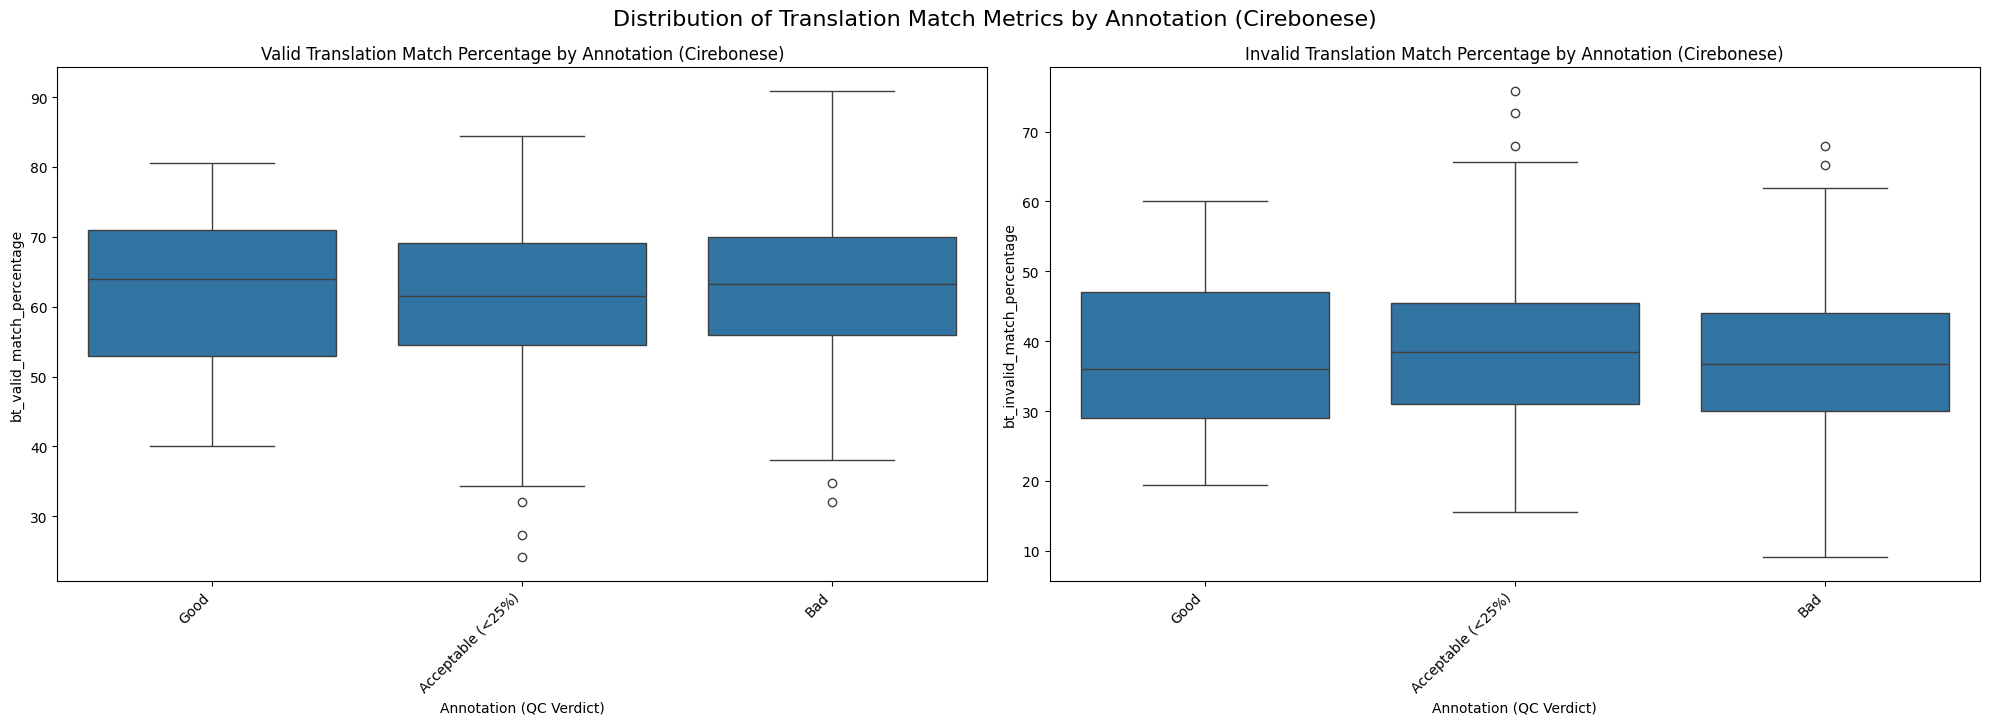

In [36]:
main_translation_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Cirebonese Quality Check - Annotation Sheets - cbn.csv",
    dict_path="/home/haznitrama/scale-resources/dict/cbn_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Cirebonese",
    use_kbbi=True
)

## MT Metrics (BLEU, WER, Word Overlap)

### Utility Codes

In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from jiwer import wer

In [26]:
def back_translate(text, ref_text, dict_map):
    src_tokens = re.findall(r"\b\w+\b", str(text).lower())
    ref_tokens = re.findall(r"\b\w+\b", str(ref_text).lower())

    back_translated_words = []

    for word_idx, word in enumerate(src_tokens):
        # Find Indonesian translations for this word (lowercase key)
        candidates_raw = dict_map.get(word, None)

        if not candidates_raw:
            back_translated_words.append(
                word
            )  # OOV: keep original (lowercased) Balinese word
            continue

        if isinstance(candidates_raw, list):
            normalized_candidates = [str(item).lower() for item in candidates_raw]
        else:  # Assuming it's a single string translation
            normalized_candidates = [str(candidates_raw).lower()]

        if not normalized_candidates:
            back_translated_words.append(
                word
            )  # Fallback if normalization results in empty list
            continue

        # Filter candidates to those present in ref_tokens and find their closest occurrence
        in_ref_candidates_details = []
        for trans_cand in normalized_candidates:
            indices_in_ref = [
                i for i, token in enumerate(ref_tokens) if token == trans_cand
            ]
            if indices_in_ref:
                # Calculate the minimum distance to the word_idx
                min_distance = min(
                    abs(ref_idx - word_idx) for ref_idx in indices_in_ref
                )
                in_ref_candidates_details.append(
                    {"translation": trans_cand, "distance": min_distance}
                )

        chosen_translation = None
        if in_ref_candidates_details:
            # Sort by distance to find the closest one
            in_ref_candidates_details.sort(key=lambda x: x["distance"])
            chosen_translation = in_ref_candidates_details[0]["translation"]
        elif (
            normalized_candidates
        ):  # No candidates found in reference, pick the first from dictionary
            chosen_translation = normalized_candidates[0]

        if chosen_translation:
            back_translated_words.append(chosen_translation)
        else:  # Fallback: should not be common if normalized_candidates had items
            back_translated_words.append(word)

    return " ".join(back_translated_words), " ".join(ref_tokens)


# Metric functions
def bleu_score(ref, hyp):
    ref_tokens = str(ref).lower().split()  # Lowercase the reference text
    hyp_tokens = (
        str(hyp).lower().split()
    )  # Hyp is already lowercase from back_translate
    smoothie = SmoothingFunction().method4
    # Ensure reference is a list of lists of tokens for sentence_bleu
    return sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)


def word_overlap(ref, hyp):
    ref_set = set(str(ref).lower().split())  # Lowercase the reference text
    hyp_set = set(str(hyp).lower().split())  # Hyp is already lowercase
    if not ref_set:  # Avoid division by zero if reference is empty
        return 0.0
    return len(ref_set & hyp_set) / len(ref_set)

In [27]:
def process_mt_metrics(data_path, dict_path, corrections_columns, threshold=25):
    """
    Processes the DataFrame from the given data path, calculates back-translation metrics.
    """
    # Load the dictionary
    dict_map = load_dict_map(dict_path)

    # Load the DataFrame
    df = pd.read_csv(data_path)
    df = process_valid_pct(
        data_path,
        dict_path,
        corrections_columns=corrections_columns,
        threshold=threshold,
    )  # Ensure valid percentages are calculated first

    # Calculate back-translation metrics
    metrics_df = df.apply(
        lambda row: back_translate(
            row["Teks Sintetis Awal"], row["Teks Referensi"], dict_map
        ),
        axis=1,
        result_type="expand",
    )

    # Rename columns for clarity
    metrics_df.columns = ["back_translated_text", "reference_text"]

    # Calculate BLEU and Word Overlap scores
    df["bleu_score"] = metrics_df.apply(
        lambda x: bleu_score(x["reference_text"], x["back_translated_text"]),
        axis=1,
    )
    df["word_overlap"] = metrics_df.apply(
        lambda x: word_overlap(x["reference_text"], x["back_translated_text"]), axis=1
    )
    df["wer"] = metrics_df.apply(
        lambda x: wer(x["reference_text"], x["back_translated_text"]), axis=1
    )

    # Combine metrics with original DataFrame
    df = pd.concat([df, metrics_df], axis=1)
    return df

def plot_mt_metrics(df, lang="Balinese", threshold=25):
    """
    Plots the back-translation metrics.
    """
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    sns.boxplot(
        data=df,
        x="original_refined_qc_verdict",
        y="bleu_score",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title(f"BLEU Score by Annotation ({lang})")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    sns.boxplot(
        data=df,
        x="original_refined_qc_verdict",
        y="word_overlap",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title(f"Word Overlap by Annotation ({lang})")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    sns.boxplot(
        data=df,
        x="original_refined_qc_verdict",
        y="wer",
        order=["Good", f"Acceptable (<{threshold}%)", "Bad"],
    )
    plt.title(f"Word Error Rate by Annotation ({lang})")
    plt.xlabel("Annotation (QC Verdict)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.suptitle(
        f"Distribution of Back-Translation Metrics by Annotation ({lang})",
        fontsize=16,
        y=1.03,
    )
    plt.show()

def print_mt_stats(df, lang="Balinese"):
    """
    Prints descriptive statistics for back-translation metrics.
    """
    print(f"\nDescriptive Statistics for Back-Translation Metrics by Annotation ({lang})")
    if "original_refined_qc_verdict" in df.columns:
        stats = (
            df.dropna(subset=["original_refined_qc_verdict"])
            .groupby("original_refined_qc_verdict")[
                ["bleu_score", "word_overlap", "wer"]
            ]
            .describe()
        )
        print(stats)
    else:
        print(
            "Warning: Column 'original_refined_qc_verdict' not found for descriptive statistics."
        )

def main_mt_metrics(
    data_path: str,
    dict_path: str,
    corrections_columns: list,
    lang: str = "Balinese",
    threshold: int = 25,
):
    """
    Main function to process the data, calculate back-translation metrics, and plot results.
    """
    df = process_mt_metrics(data_path, dict_path, corrections_columns)

    # Print descriptive statistics
    print_mt_stats(df, lang)

    # Plot back-translation metrics
    plot_mt_metrics(df, lang)

### Analysis

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/bali_idn.json with 20021 entries.

Descriptive Statistics for Back-Translation Metrics by Annotation (Balinese)
                            bleu_score                                \
                                 count      mean       std       min   
original_refined_qc_verdict                                            
Acceptable (<25%)                135.0  0.577228  0.225194  0.014031   
Bad                              101.0  0.562936  0.196003  0.022140   
Good                              64.0  0.267695  0.278865  0.024843   

                                                               word_overlap  \
                                  25%       50%       75%  max        count   
original_refined_qc_verdict                                                   
Acceptable (<25%)            0.481767  0.598343  0.736057  1.0        135.0   
Bad                          0.455613  0.582064  0.694864  1.0   

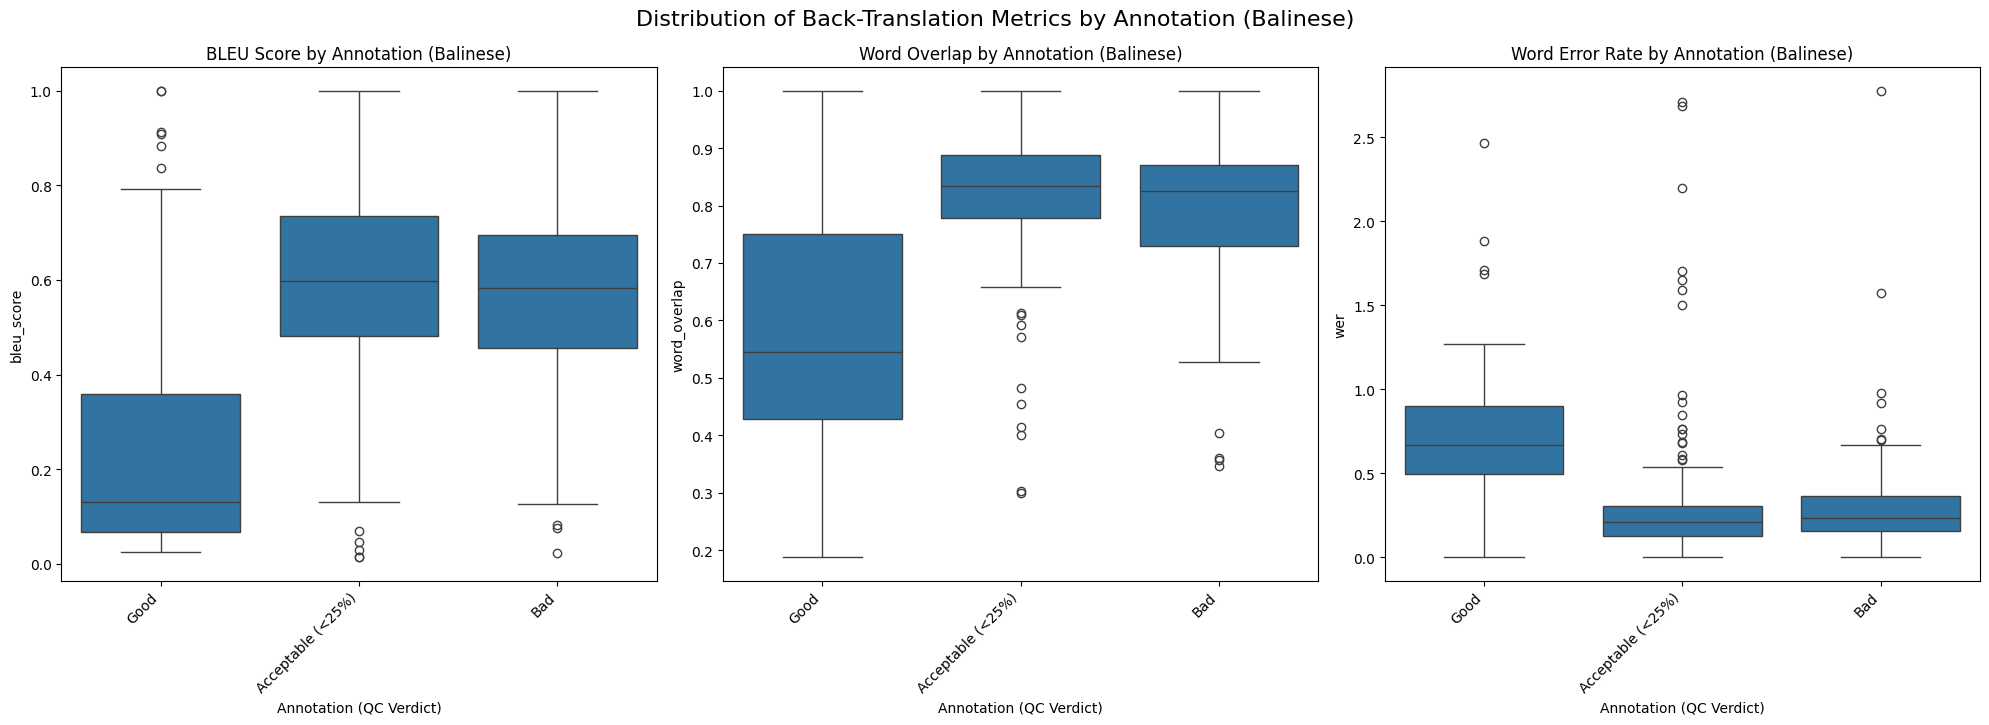

In [28]:
main_mt_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Balinese Quality Check - Annotation Sheets - ban.csv",
    dict_path="/home/haznitrama/scale-resources/dict/bali_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Balinese"
)

Successfully loaded dictionary from /home/haznitrama/scale-resources/dict/cbn_idn.json with 15681 entries.

Descriptive Statistics for Back-Translation Metrics by Annotation (Cirebonese)
                            bleu_score                                \
                                 count      mean       std       min   
original_refined_qc_verdict                                            
Acceptable (<25%)                125.0  0.574325  0.189407  0.013905   
Bad                              138.0  0.487626  0.184087  0.078869   
Good                              37.0  0.613095  0.225332  0.046042   

                                                                     \
                                  25%       50%       75%       max   
original_refined_qc_verdict                                           
Acceptable (<25%)            0.457743  0.563933  0.710161  1.000000   
Bad                          0.349719  0.480381  0.584936  0.967168   
Good                     

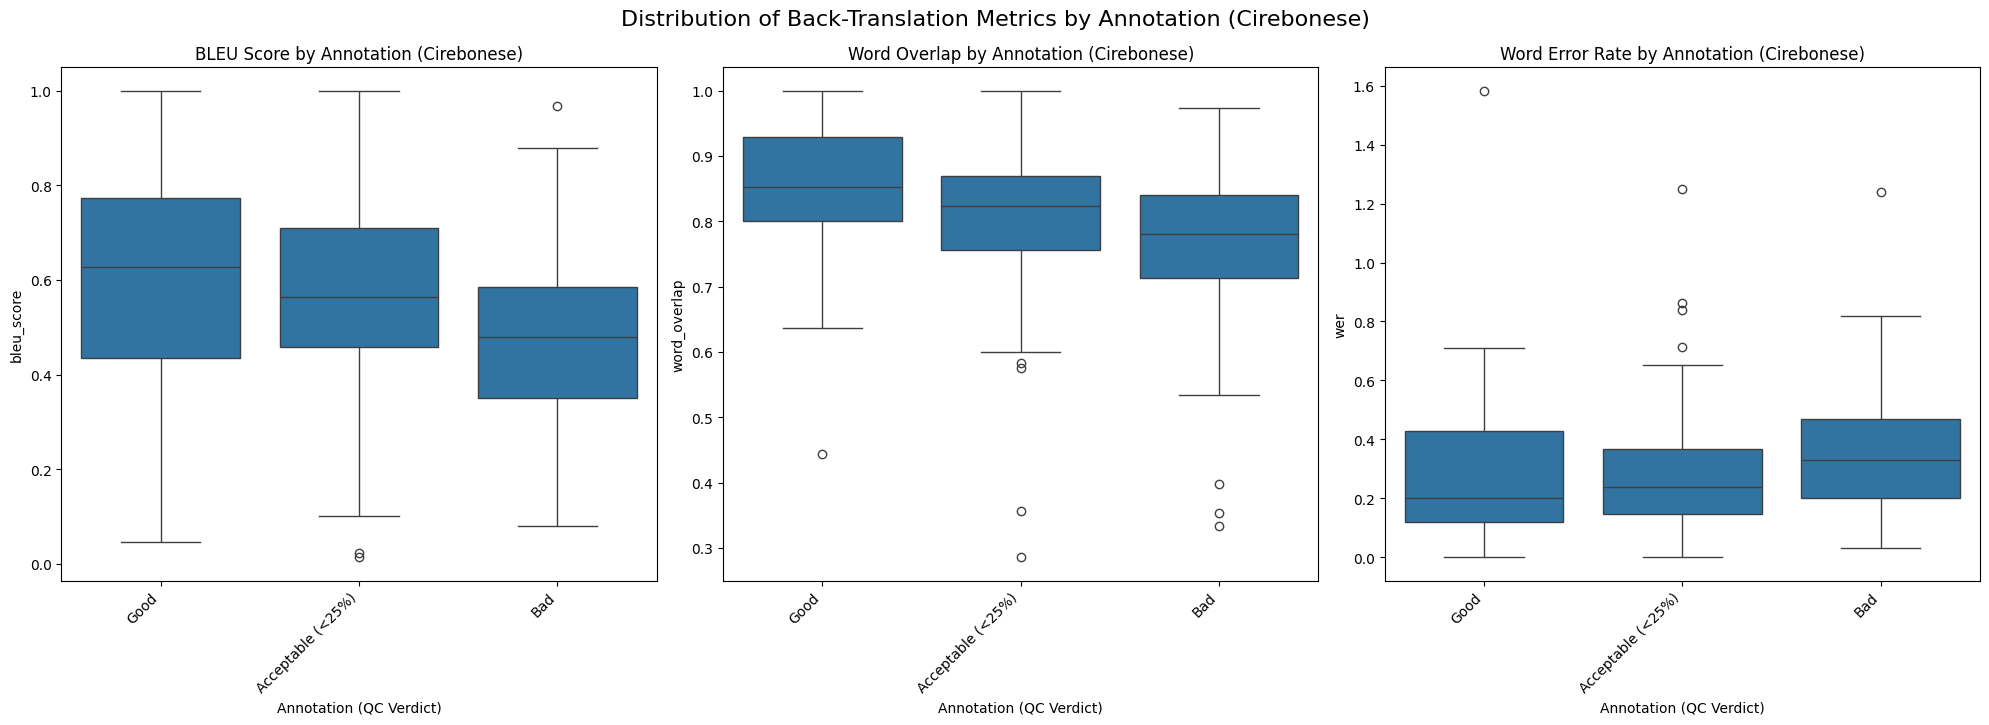

In [29]:
main_mt_metrics(
    data_path="/home/haznitrama/scale-resources/dataset/annotation/Cirebonese Quality Check - Annotation Sheets - cbn.csv",
    dict_path="/home/haznitrama/scale-resources/dict/cbn_idn.json",
    corrections_columns=["ANT01 Perbaikan", "ANT02 Perbaikan"],
    lang="Cirebonese"
)